In [1]:
!pip install efficientnet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255) 

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                   target_size = (208,208),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 4098 images belonging to 4 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                  target_size = (208,208),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1023 images belonging to 4 classes.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


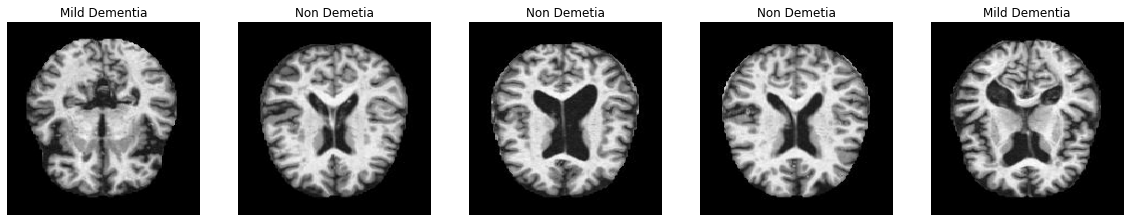

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [7]:
base_model = enet.EfficientNetB0(input_shape=(208,208,3), 
                                 include_top=False,
                                 weights="imagenet")

In [8]:
for layer in base_model.layers:
    layer.trainable=False

In [9]:
model=Sequential()
model.add(base_model)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
average_pooling2d (AveragePo (None, 3, 3, 1280)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 1280)        5120      
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11520)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11520)             46080     
_________________________________________________________________
dense (Dense)                (None, 512)               5

In [11]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.RMSprop(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [12]:
filepath = './model_tuning208_512_RMSprop1e3.h5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint]

In [13]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                         
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 1.2078 - auc: 0.7866
Epoch 00001: val_auc improved from -inf to 0.70354, saving model to .\model_tuning208_512_RMSprop1e3.h5
65/65 [==============================] - 148s 2s/step - loss: 1.2078 - auc: 0.7866 - val_loss: 1.2357 - val_auc: 0.7035
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.9066 - auc: 0.8663
Epoch 00002: val_auc did not improve from 0.70354
65/65 [==============================] - 134s 2s/step - loss: 0.9066 - auc: 0.8663 - val_loss: 1.4221 - val_auc: 0.6260
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.8214 - auc: 0.8876
Epoch 00003: val_auc did not improve from 0.70354
65/65 [==============================] - 133s 2s/step - loss: 0.8214 - auc: 0.8876 - val_loss: 1.4667 - val_auc: 0.6004
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 0.7260 - auc: 0.9085
Epoch 00004: val_auc did not improve from 0.70354
65/65 [===================

65/65 [==============================] - ETA: 0s - loss: 0.2906 - auc: 0.9839
Epoch 00030: val_auc did not improve from 0.93505
65/65 [==============================] - 142s 2s/step - loss: 0.2906 - auc: 0.9839 - val_loss: 0.7380 - val_auc: 0.9165
Epoch 31/100
65/65 [==============================] - ETA: 0s - loss: 0.2864 - auc: 0.9838
Epoch 00031: val_auc did not improve from 0.93505
65/65 [==============================] - 133s 2s/step - loss: 0.2864 - auc: 0.9838 - val_loss: 0.6755 - val_auc: 0.9276
Epoch 32/100
65/65 [==============================] - ETA: 0s - loss: 0.2664 - auc: 0.9865
Epoch 00032: val_auc did not improve from 0.93505
65/65 [==============================] - 132s 2s/step - loss: 0.2664 - auc: 0.9865 - val_loss: 0.6744 - val_auc: 0.9278
Epoch 33/100
65/65 [==============================] - ETA: 0s - loss: 0.2608 - auc: 0.9868
Epoch 00033: val_auc improved from 0.93505 to 0.93861, saving model to .\model_tuning208_512_RMSprop1e3.h5
65/65 [=========================

65/65 [==============================] - 134s 2s/step - loss: 0.1805 - auc: 0.9927 - val_loss: 0.5536 - val_auc: 0.9520
Epoch 61/100
65/65 [==============================] - ETA: 0s - loss: 0.1888 - auc: 0.9918
Epoch 00061: val_auc did not improve from 0.95201
65/65 [==============================] - 136s 2s/step - loss: 0.1888 - auc: 0.9918 - val_loss: 0.6237 - val_auc: 0.9425
Epoch 62/100
65/65 [==============================] - ETA: 0s - loss: 0.1823 - auc: 0.9929
Epoch 00062: val_auc did not improve from 0.95201
65/65 [==============================] - 138s 2s/step - loss: 0.1823 - auc: 0.9929 - val_loss: 0.6018 - val_auc: 0.9444
Epoch 63/100
65/65 [==============================] - ETA: 0s - loss: 0.1821 - auc: 0.9925
Epoch 00063: val_auc did not improve from 0.95201
65/65 [==============================] - 134s 2s/step - loss: 0.1821 - auc: 0.9925 - val_loss: 0.6435 - val_auc: 0.9414
Epoch 64/100
65/65 [==============================] - ETA: 0s - loss: 0.1855 - auc: 0.9924
Epoch 

Epoch 91/100
65/65 [==============================] - ETA: 0s - loss: 0.1307 - auc: 0.9963
Epoch 00091: val_auc did not improve from 0.96458
65/65 [==============================] - 131s 2s/step - loss: 0.1307 - auc: 0.9963 - val_loss: 0.5710 - val_auc: 0.9542
Epoch 92/100
65/65 [==============================] - ETA: 0s - loss: 0.1422 - auc: 0.9952
Epoch 00092: val_auc did not improve from 0.96458
65/65 [==============================] - 132s 2s/step - loss: 0.1422 - auc: 0.9952 - val_loss: 0.5305 - val_auc: 0.9570
Epoch 93/100
65/65 [==============================] - ETA: 0s - loss: 0.1548 - auc: 0.9946
Epoch 00093: val_auc did not improve from 0.96458
65/65 [==============================] - 132s 2s/step - loss: 0.1548 - auc: 0.9946 - val_loss: 0.5223 - val_auc: 0.9588
Epoch 94/100
65/65 [==============================] - ETA: 0s - loss: 0.1272 - auc: 0.9960
Epoch 00094: val_auc did not improve from 0.96458
65/65 [==============================] - 134s 2s/step - loss: 0.1272 - auc: 

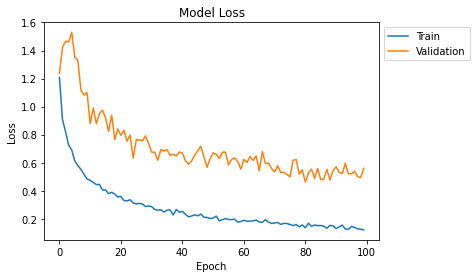

In [24]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

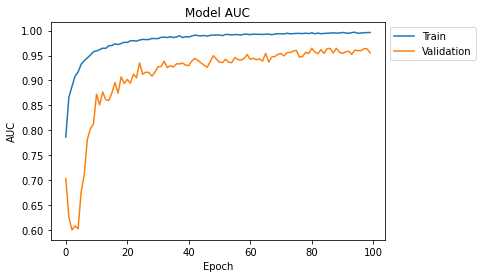

In [25]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

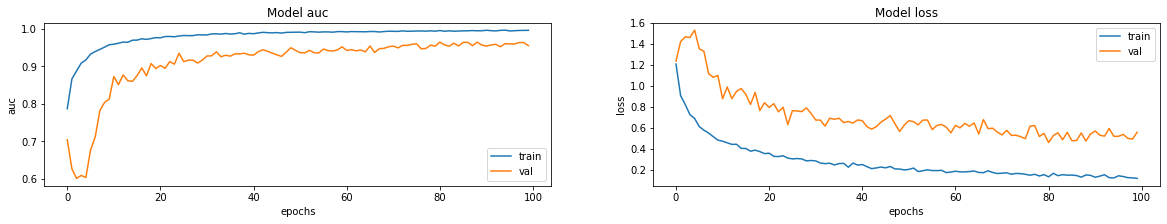

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [17]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/test',
                                                 target_size = (208,208),
                                                 class_mode = 'categorical',
                                                 batch_size = 64)

Found 1279 images belonging to 4 classes.


In [23]:
model.evaluate(test_dataset)

20/20 [==============================] - 50s 2s/step - loss: 1.1921 - auc: 0.9006


[1.192131757736206, 0.9005995392799377]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
99.29 % chances are there that the image is NonDemented


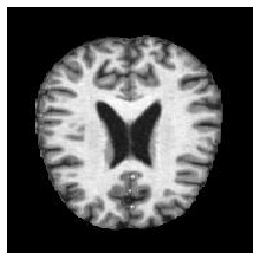

In [19]:
# Test Case 1: Non-Dementia

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (208,208,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

83.96 % chances are there that the image is MildDemented


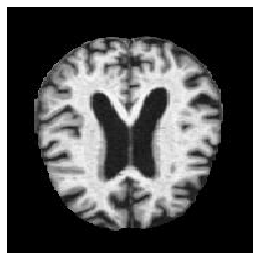

In [20]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

100.0 % chances are there that the image is ModerateDemented


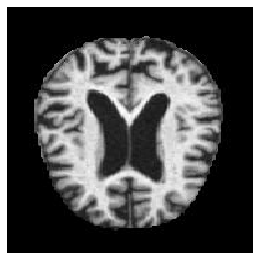

In [21]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

94.1 % chances are there that the image is VeryMildDemented


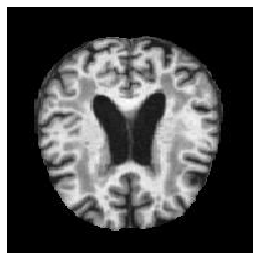

In [22]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])